In [1]:
import itertools
import os
import collections
import sys
import traceback
import matplotlib
import pygly2
from pygly2 import monosaccharides
from pygly2.composition import Composition, composition_transform
from pygly2.structure import (glycan, monosaccharide, substituent,
                              Anomer, Configuration, SuperClass,
                              Substituent, Glycan, Monosaccharide,
                              crossring_fragments)
from pygly2.io.nomenclature import identity
from pygly2.io import glycoct, glycomedb
from pygly2 import plot
from pygly2.algorithms import subtree_search, similarity, database
import tests
%matplotlib inline

derivatize = composition_transform.derivatize
_human_db_path = '../test_data/human_rec.db'

In [2]:
big = tests.load("common_glycan")
broad = tests.load("broad_n_glycan")
branchy = tests.load("branchy_glycan")
complicated = tests.load("complex_glycan")
human_db = database.RecordDatabase(_human_db_path)
ncore = pygly2.glycans["N-Linked Core"]

In [3]:
default_fragmentation_parameters = {
    "kind": "BYX",
    "max_cleavages": 2,
    "average": False,
    "charge": 0
}

def extract_fragments(record, fragmentation_parameters=None):
    fragmentation_parameters = fragmentation_parameters or default_fragmentation_parameters
    container = collections.defaultdict(dict)
    for frag in record.structure.fragments(**fragmentation_parameters):
        container[frag.kind][tuple(frag.included_nodes)] = frag
    return container

class FragmentedGlycanRecord(database.GlycanRecord):
    extract_fragments = staticmethod(extract_fragments)


In [4]:
os.remove("./human_n_glycan2.db")
ndb = database.RecordDatabase("./human_n_glycan2.db")
for record in human_db:
    if subtree_search.subtree_of(ncore, record.structure, exact=False):
        ndb.create(record.structure)


In [5]:
ndb.apply_indices()
ndb.commit()

In [6]:
len(ndb)

820

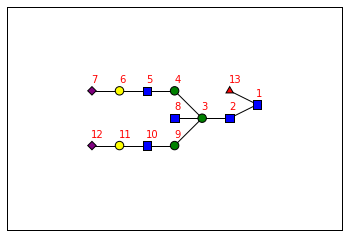

In [23]:
plot.enumerate_tree(*plot.plot(ndb[819]))

In [26]:
ndb[819].structure.get(13)

RES 1b:a-dgal-HEX-1:5|6:d

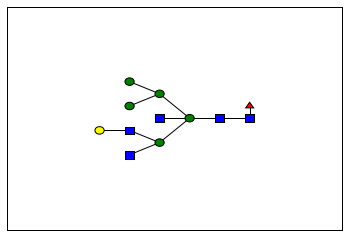

In [32]:
c = glycoct.loads('''RES
1b:b-dglc-HEX-1:5
2s:n-acetyl
3b:b-dglc-HEX-1:5
4s:n-acetyl
5b:b-dman-HEX-1:5
6b:a-dman-HEX-1:5
7b:a-dman-HEX-1:5
8b:a-dman-HEX-1:5
9b:a-dman-HEX-1:5
10b:b-dglc-HEX-1:5
11s:n-acetyl
12b:b-dgal-HEX-1:5
13b:b-dglc-HEX-1:5
14s:n-acetyl
15b:b-dglc-HEX-1:5
16s:n-acetyl
17b:a-lgal-HEX-1:5|6:d
LIN
1:1d(2+1)2n
2:1o(4+1)3d
3:1o(6+1)17d
4:3d(2+1)4n
5:3o(4+1)5d
6:5o(3+1)9d
7:5o(4+1)15d
8:5o(6+1)6d
9:6o(3+1)8d
10:6o(6+1)7d
11:9o(2+1)13d
12:9o(4+1)10d
13:10d(2+1)11n
14:10o(4+1)12d
15:13d(2+1)14n
16:15d(2+1)16n''').next()

dtree, ax = plot.plot(c)

In [16]:
subtree_search.subtree_of(ncore, c, exact=False)

1

In [29]:
similarity.monosaccharide_similarity(pygly2.monosaccharides.Fuc, ndb[819].structure.get(13))

(4, 5)

In [30]:
ndb[819].structure.get

RES
1b:b-dglc-HEX-1:5
2s:n-acetyl
3b:b-dglc-HEX-1:5
4s:n-acetyl
5b:b-dman-HEX-1:5
6b:a-dman-HEX-1:5
7b:b-dglc-HEX-1:5
8s:n-acetyl
9b:b-dgal-HEX-1:5
10b:a-dgro-dgal-NON-2:6|1:a|2:keto|3:d
11s:n-acetyl
12b:b-dglc-HEX-1:5
13s:n-acetyl
14b:a-dman-HEX-1:5
15b:b-dglc-HEX-1:5
16s:n-acetyl
17b:b-dgal-HEX-1:5
18b:a-dgro-dgal-NON-2:6|1:a|2:keto|3:d
19s:n-acetyl
20b:a-dgal-HEX-1:5|6:d
LIN
1:1d(2+1)2n
2:1o(4+1)3d
3:1o(6+1)20d
4:3d(2+1)4n
5:3o(4+1)5d
6:5o(3+1)14d
7:5o(4+1)12d
8:5o(6+1)6d
9:6o(2+1)7d
10:7d(2+1)8n
11:7o(4+1)9d
12:9o(6+2)10d
13:10d(5+1)11n
14:12d(2+1)13n
15:14o(2+1)15d
16:15d(2+1)16n
17:15o(4+1)17d
18:17o(6+2)18d
19:18d(5+1)19n

In [8]:
map(dict, human_db.execute("select max(glycan_id) from {table_name};"))

[{'max(glycan_id)': 3043}]

In [9]:
subtree_search.subtree_of(pygly2.glycans['N-Linked Core'], ncore)

1

In [31]:
pygly2.monosaccharides.Fuc

RES 1b:a-lgal-HEX-1:5|6:d

In [35]:
ax.get_visible()

True

In [8]:
x=pygly2.composition.structure_composition.modification_compositions["aldi"]

In [9]:
x.composition

Composition({'H': 2})